In [2]:
#import the torch and transform
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
#
#download the cifar-10 and define it
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#define a CNN and modify it to take 3-channel images
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnnet = Net()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
#define the Loss function
# Using the Classification Cross-Entropy loss and SGD with momentum
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnet.parameters(), lr=0.001, momentum=0.9)

In [6]:
# function validate the network performance over the testloader
def model_valid(model,dataset):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataset:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    return float(correct)/float(total)


# function that iterate the dataset and print the validation result
def train(model,trainloader,testloader,iteration=10):
    train_acc=[]
    test_acc=[]
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # feed the inputs to the network and optimize
    for epoch in range(iteration):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()        

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
        train_acc.append(model_valid(model,trainloader))
        test_acc.append(model_valid(model,testloader))

    print('Finished Training')
    return model,train_acc,test_acc

cnn_net_model, train_acc_cnn, test_acc_cnn = train(cnnet,trainloader,testloader,10)

[1,  2000] loss: 2.253
[1,  4000] loss: 1.938
[1,  6000] loss: 1.722
[1,  8000] loss: 1.589
[1, 10000] loss: 1.544
[1, 12000] loss: 1.470
Accuracy of the network on the 10000 test images: 49 %
Accuracy of the network on the 10000 test images: 48 %
[2,  2000] loss: 1.415
[2,  4000] loss: 1.398
[2,  6000] loss: 1.374
[2,  8000] loss: 1.336
[2, 10000] loss: 1.315
[2, 12000] loss: 1.310
Accuracy of the network on the 10000 test images: 55 %
Accuracy of the network on the 10000 test images: 54 %
[3,  2000] loss: 1.240
[3,  4000] loss: 1.253
[3,  6000] loss: 1.237
[3,  8000] loss: 1.231
[3, 10000] loss: 1.207
[3, 12000] loss: 1.196
Accuracy of the network on the 10000 test images: 59 %
Accuracy of the network on the 10000 test images: 56 %
[4,  2000] loss: 1.125
[4,  4000] loss: 1.133
[4,  6000] loss: 1.119
[4,  8000] loss: 1.140
[4, 10000] loss: 1.136
[4, 12000] loss: 1.141
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 59 %
[5,  200

In [14]:
### compare accuracy of the CNN and the accuracy of simple dense neural networks
### with 0, 1, 2, 3 and 4 hidden layers of 512 rectified linear units over the cifar10 dataset
#build a simple dense neural network with adjustable of hidden layers 

class Simple_NN(nn.Module):
    def __init__(self,num):
        super().__init__()
        self.num = num
        self.layers=[]
        self.f1 = nn.Linear(3072,512)
        for i in range(self.num):
            self.layers.append(nn.Linear(512,512))
        self.f2 = nn.Linear(512,10)
        
    def forward(self, x):
        x = x.view(-1,3072) 
        x = F.relu(self.f1(x))
        for i in range(self.num):
            x = F.relu(self.layers[i](x))
        x = F.dropout(x,p=0.5) 
        x = self.f2(x)
        return x 

#with layer 0
S0 = Simple_NN(0)
S_0_model, train_acc_nn_0, test_acc_nn_0 = train(S0,trainloader,testloader,10)


#with layer 1
S1 = Simple_NN(1)
S_1_model, train_acc_nn_1, test_acc_nn_1 = train(S1,trainloader,testloader,10)


#with layer 2
S2 = Simple_NN(2)
S_2_model, train_acc_nn_2, test_acc_nn_2 = train(S2,trainloader,testloader,10)


#with layer 3
S3 = Simple_NN(3)
S_3_model, train_acc_nn_3, test_acc_nn_3 = train(S3,trainloader,testloader,10)


#with layer 4
S4 = Simple_NN(4)
S_4_model, train_acc_nn_4, test_acc_nn_4 = train(S4,trainloader,testloader,10)



[1,  2000] loss: 1.929
[1,  4000] loss: 1.879
[1,  6000] loss: 1.867
[1,  8000] loss: 1.872
[1, 10000] loss: 1.873
[1, 12000] loss: 1.866
Accuracy of the network on the 10000 test images: 37 %
Accuracy of the network on the 10000 test images: 36 %
[2,  2000] loss: 1.837
[2,  4000] loss: 1.852
[2,  6000] loss: 1.843
[2,  8000] loss: 1.866
[2, 10000] loss: 1.866
[2, 12000] loss: 1.860
Accuracy of the network on the 10000 test images: 40 %
Accuracy of the network on the 10000 test images: 39 %
[3,  2000] loss: 1.836
[3,  4000] loss: 1.817
[3,  6000] loss: 1.858
[3,  8000] loss: 1.813
[3, 10000] loss: 1.802
[3, 12000] loss: 1.818
Accuracy of the network on the 10000 test images: 43 %
Accuracy of the network on the 10000 test images: 40 %
[4,  2000] loss: 1.789
[4,  4000] loss: 1.824
[4,  6000] loss: 1.824
[4,  8000] loss: 1.766
[4, 10000] loss: 1.778
[4, 12000] loss: 1.801
Accuracy of the network on the 10000 test images: 44 %
Accuracy of the network on the 10000 test images: 41 %
[5,  200

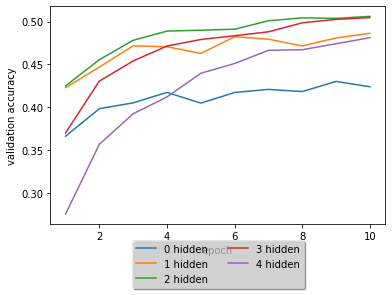

In [18]:
# plot the the accuracy of the convolutional neural network on the cifar10 
# dataset to the accuracy of simple dense neural networks with 0, 1, 2, 3 
# and 4 hidden layers of 512 rectified linear units each. 
epoch = range(1,11)
#plt.plot(epoch,test_acc_cnn,label=f"CNN") 
plt.plot(epoch,test_acc_nn_0,label=f"0 hidden") 
plt.plot(epoch,test_acc_nn_1,label=f"1 hidden")
plt.plot(epoch,test_acc_nn_2,label=f"2 hidden")
plt.plot(epoch,test_acc_nn_3,label=f"3 hidden")
plt.plot(epoch,test_acc_nn_4,label=f"4 hidden")
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
leg = plt.legend(loc='upper center', ncol=2, shadow=True, fancybox=True, bbox_to_anchor=(0.5, -0.05))
leg.get_frame().set_alpha(0.5)
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,  2000] loss: 2.317
[1,  4000] loss: 2.315
[1,  6000] loss: 2.315
[1,  8000] loss: 2.312
[1, 10000] loss: 2.310
[1, 12000] loss: 2.312
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 10 %
[2,  2000] loss: 2.310
[2,  4000] loss: 2.309
[2,  6000] loss: 2.308
[2,  8000] loss: 2.309
[2, 10000] loss: 2.307
[2, 12000] loss: 2.306
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 10 %
[3,  2000] loss: 2.307
[3,  4000] loss: 2.307
[3,  6000] loss: 2.306
[3,  8000] loss: 2.305
[3, 10000] loss: 2.305
[3, 12000] loss: 2.304
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 10 %
[4,  2000] loss: 2.305
[4,  4000] loss: 2.306
[4,  6000] loss: 2.304
[4,  8000] loss: 2.305
[4, 10000] loss: 2.305
[4, 12000] loss: 2.305
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 10 %
[5,  200

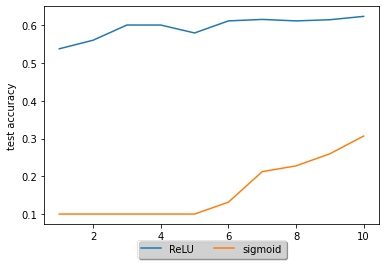

In [13]:
#b) Compare the accuracy achieved by rectified linear units and sigmoid units 
### in the convolutional neural network in the code

#build the CNN using Sigmoid instead of Relu
class CNN_S(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

SNN = CNN_S()

#get the validation result using CNN with sigmoid function over cifar
s_model, train_acc_sig, test_acc_sig = train(SNN,trainloader,testloader,10)

### compare the accuracy 
epoch = [1,2,3,4,5,6,7,8,9,10]
plt.plot(epoch,test_acc_cnn,label=f"ReLU") 
plt.plot(epoch,test_acc_sig,label=f"sigmoid") 
plt.ylabel('test accuracy')
leg = plt.legend(loc='upper center', ncol=2, shadow=True, fancybox=True, bbox_to_anchor=(0.5, -0.05))
leg.get_frame().set_alpha(0.5)
plt.show()


Answer: Comparing the CNN Using Relu and Sigmoid, Relu is better fitting as it has better linear fitting and avoids gradient vanishing.

In [8]:
# C) Compare the accuracy achieved with and without drop out as well as
##  with and without data augmentation in the convolutional neural network


### cnn with drop out

class Dropout_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x,p=0.5) 
        x = F.relu(self.fc2(x))
        x = F.dropout(x,p=0.5) 
        x = self.fc3(x)
        return x

cnn_d = Dropout_cnn()

#validation and train using CNN with drop out with 15 iterations
cnn_drop_model, train_acc_drop, test_acc_drop = train(cnn_d,trainloader,testloader,15)
#validation and train with CNN without drop out with 15 iterations
cnn_model, train_acc_cnn, test_acc_cnn = train(cnnet,trainloader,testloader,15)


[1,  2000] loss: 2.241
[1,  4000] loss: 2.031
[1,  6000] loss: 1.887
[1,  8000] loss: 1.818
[1, 10000] loss: 1.737
[1, 12000] loss: 1.699
Accuracy of the network on the 10000 test images: 37 %
Accuracy of the network on the 10000 test images: 37 %
[2,  2000] loss: 1.635
[2,  4000] loss: 1.618
[2,  6000] loss: 1.592
[2,  8000] loss: 1.578
[2, 10000] loss: 1.570
[2, 12000] loss: 1.574
Accuracy of the network on the 10000 test images: 45 %
Accuracy of the network on the 10000 test images: 44 %
[3,  2000] loss: 1.515
[3,  4000] loss: 1.506
[3,  6000] loss: 1.503
[3,  8000] loss: 1.491
[3, 10000] loss: 1.482
[3, 12000] loss: 1.453
Accuracy of the network on the 10000 test images: 46 %
Accuracy of the network on the 10000 test images: 46 %
[4,  2000] loss: 1.444
[4,  4000] loss: 1.452
[4,  6000] loss: 1.421
[4,  8000] loss: 1.435
[4, 10000] loss: 1.419
[4, 12000] loss: 1.417
Accuracy of the network on the 10000 test images: 51 %
Accuracy of the network on the 10000 test images: 49 %
[5,  200

In [9]:
###data augmentation

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5),  
     transforms.RandomGrayscale(p=0.5), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader_aug = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader_aug = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
#with and without dropout training validation (with data augmentation)
cnn_aug = Net()
cnn_aug_no_drop, train_acc_aug, test_acc_aug = train(cnn_aug,trainloader_aug,testloader_aug,15)

cnn_aug_drop = Dropout_cnn()
cnn_aug_with_drop, train_acc_drop_aug, test_acc_drop_aug = train(cnn_aug_drop,trainloader_aug,testloader_aug,15)

[1,  2000] loss: 2.232
[1,  4000] loss: 1.910
[1,  6000] loss: 1.726
[1,  8000] loss: 1.658
[1, 10000] loss: 1.594
[1, 12000] loss: 1.571
Accuracy of the network on the 10000 test images: 44 %
Accuracy of the network on the 10000 test images: 43 %
[2,  2000] loss: 1.481
[2,  4000] loss: 1.456
[2,  6000] loss: 1.411
[2,  8000] loss: 1.372
[2, 10000] loss: 1.335
[2, 12000] loss: 1.353
Accuracy of the network on the 10000 test images: 55 %
Accuracy of the network on the 10000 test images: 53 %
[3,  2000] loss: 1.284
[3,  4000] loss: 1.276
[3,  6000] loss: 1.258
[3,  8000] loss: 1.247
[3, 10000] loss: 1.226
[3, 12000] loss: 1.222
Accuracy of the network on the 10000 test images: 60 %
Accuracy of the network on the 10000 test images: 57 %
[4,  2000] loss: 1.169
[4,  4000] loss: 1.167
[4,  6000] loss: 1.163
[4,  8000] loss: 1.160
[4, 10000] loss: 1.150
[4, 12000] loss: 1.123
Accuracy of the network on the 10000 test images: 62 %
Accuracy of the network on the 10000 test images: 60 %
[5,  200

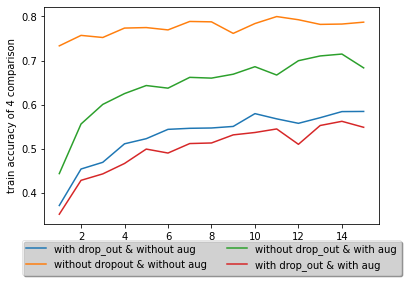

In [11]:
#plot 1 for training accuracy
epoch = range(1,16)
plt.plot(epoch,train_acc_drop,label=f"with drop_out & without aug") 
plt.plot(epoch,train_acc_cnn,label=f"without dropout & without aug") 
plt.plot(epoch,train_acc_aug,label=f"without drop_out & with aug") 
plt.plot(epoch,train_acc_drop_aug,label=f"with drop_out & with aug") 
plt.ylabel('train accuracy of 4 comparison')
leg = plt.legend(loc='upper center', ncol=2, shadow=True, fancybox=True, bbox_to_anchor=(0.5, -0.05))
leg.get_frame().set_alpha(0.5)
plt.show()

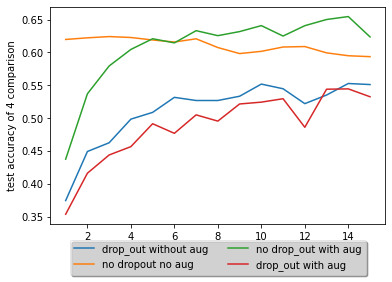

In [13]:
#plot 2 for test accuracy
epoch = range(1,16)
plt.plot(epoch,test_acc_drop,label=f"drop_out without aug") 
plt.plot(epoch,test_acc_cnn,label=f"no dropout no aug") 
plt.plot(epoch,test_acc_aug,label=f"no drop_out with aug") 
plt.plot(epoch,test_acc_drop_aug,label=f"drop_out with aug") 
plt.ylabel('test accuracy of 4 comparison')
leg = plt.legend(loc='upper center', ncol=2, shadow=True, fancybox=True, bbox_to_anchor=(0.5, -0.05))
leg.get_frame().set_alpha(0.5)
plt.show()

Ans: From plot1, the training accuracy without drop_out and without augmentation gives the highest accuracy. In the testing dataset, with augmentation and no drop_out gives the best accuracy. As itearation approach 100, the accuracy increase and finally will converge to an accuracy.